Saved 'primary_fold_predictions.csv'
AUC-PR: 0.8908 | AUC-ROC: 0.6825
Sens: 90.43% | Spec: 34.78% | Precision (PPV): 85.00%


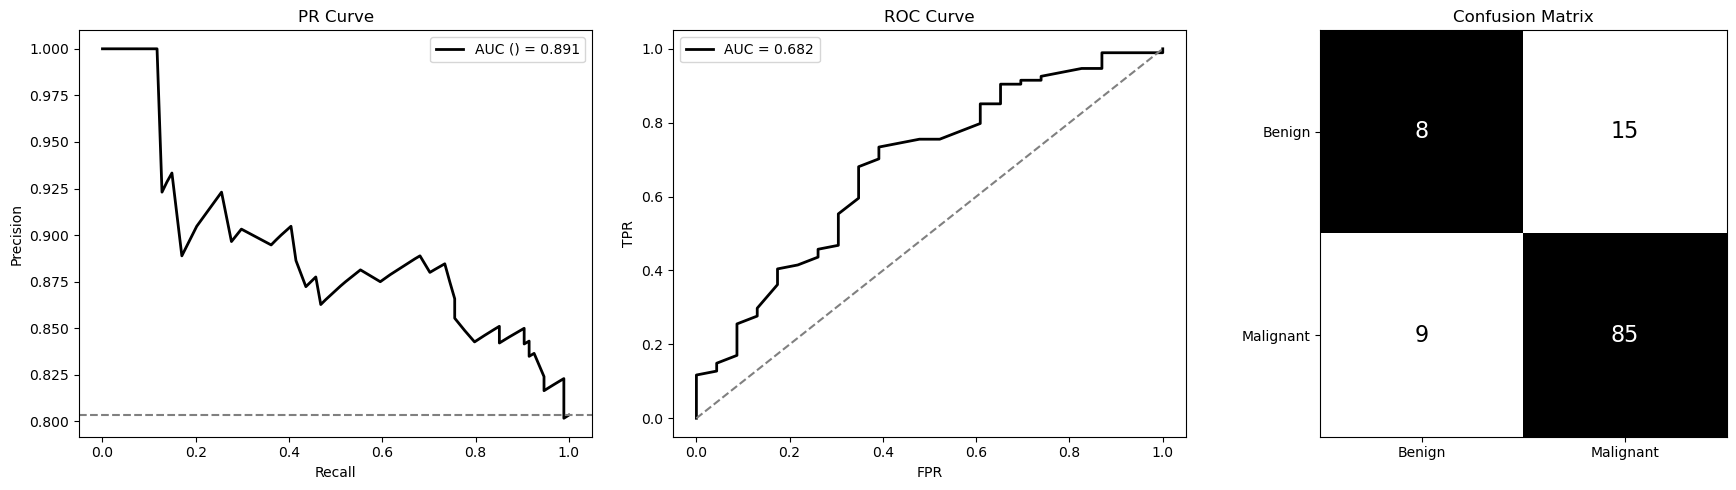

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE 
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN

df = pd.read_csv('mvb_cradjmetaboliteprofiling.csv')
sample_ids = df['Sample'].str.replace('_CrAdj', '') # Clean sample IDs
y = df['Tumor State'].map({'Malignant': 1, 'Benign': 0}) if df['Tumor State'].dtype == 'O' else df['Tumor State'].astype(int)
X = df.drop(columns=['Sample', 'Tumor State']).dropna(axis=1, thresh=len(df)*0.5)
rf_sel = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)
pipe = ImbPipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=rf_sel, n_features_to_select=15)),
    ('adasyn', ADASYN(random_state=888)), 
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_all, probs_all = [], []
pred_dfs = []
cv_metrics = {'roc_auc': [], 'pr_auc': []}

for fold_num, (tr_idx, te_idx) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    ids_te = sample_ids.iloc[te_idx]
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict_proba(X_te)[:, 1]
    
    fold_data = pd.DataFrame({
        'sample_id': ids_te.values,
        'true_label': y_te.values,
        'pred_probability': preds,
        'fold_id': fold_num
    })
    pred_dfs.append(fold_data)
    y_all.extend(y_te)
    probs_all.extend(preds)
    cv_metrics['roc_auc'].append(roc_auc_score(y_te, preds))
    cv_metrics['pr_auc'].append(average_precision_score(y_te, preds))

predictions = pd.concat(pred_dfs, ignore_index=True)
y_all = np.array(y_all)
probs_all = np.array(probs_all)
fpr, tpr, thresh = roc_curve(y_all, probs_all)
roc_auc = auc(fpr, tpr)
j_stats = tpr - fpr
best_idx = np.argmax(j_stats)
cutoff = thresh[best_idx]
predictions['pred_label'] = (predictions['pred_probability'] >= cutoff).astype(int)
predictions.to_csv('primary_fold_predictions.csv', index=False)
print(f"Saved 'primary_fold_predictions.csv'")

probs = probs_all
y = y_all

t = 0.51 #.63 threshold may yield more balanced results
preds = (probs >= t).astype(int)
tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
auc_roc = roc_auc_score(y, probs)
auc_pr = average_precision_score(y, probs)
print(f"AUC-PR: {auc_pr:.4f} | AUC-ROC: {auc_roc:.4f}")
print(f"Sens: {tp/(tp+fn):.2%} | Spec: {tn/(tn+fp):.2%} | Precision (PPV): {tp/(tp+fp):.2%}")

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
prec, rec, _ = precision_recall_curve(y, probs)
ax[0].plot(rec, prec, 'k-', lw=2, label=f'AUC () = {auc_pr:.3f}')
ax[0].axhline(y=y.mean(), color='gray', ls='--')
ax[0].set_title('PR Curve'); ax[0].set_xlabel('Recall'); ax[0].set_ylabel('Precision'); ax[0].legend()
fpr, tpr, _ = roc_curve(y, probs)
ax[1].plot(fpr, tpr, 'k-', lw=2, label=f'AUC = {auc_roc:.3f}')
ax[1].plot([0, 1], [0, 1], 'gray', ls='--')
ax[1].set_title('ROC Curve'); ax[1].set_xlabel('FPR'); ax[1].set_ylabel('TPR'); ax[1].legend()
mask = np.array([[1, 0], [0, 1]])
ax[2].imshow(mask, cmap='binary', interpolation='nearest')
cm = confusion_matrix(y, preds)
for i in range(2):
    for j in range(2):
        ax[2].text(j, i, cm[i, j], ha="center", va="center", color="white" if mask[i, j] else "black", fontsize=16)
ax[2].set_title('Confusion Matrix'); ax[2].set_xticks([0,1]); ax[2].set_yticks([0,1])
ax[2].set_xticklabels(['Benign', 'Malignant']); ax[2].set_yticklabels(['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

Saved 'secondary_fold_predictions.csv'
AUC-PR: 0.910 | AUC-ROC: 0.694
Sensitivity: 79.79% | Specificity: 56.52% | Precision (PPV): 88.24%


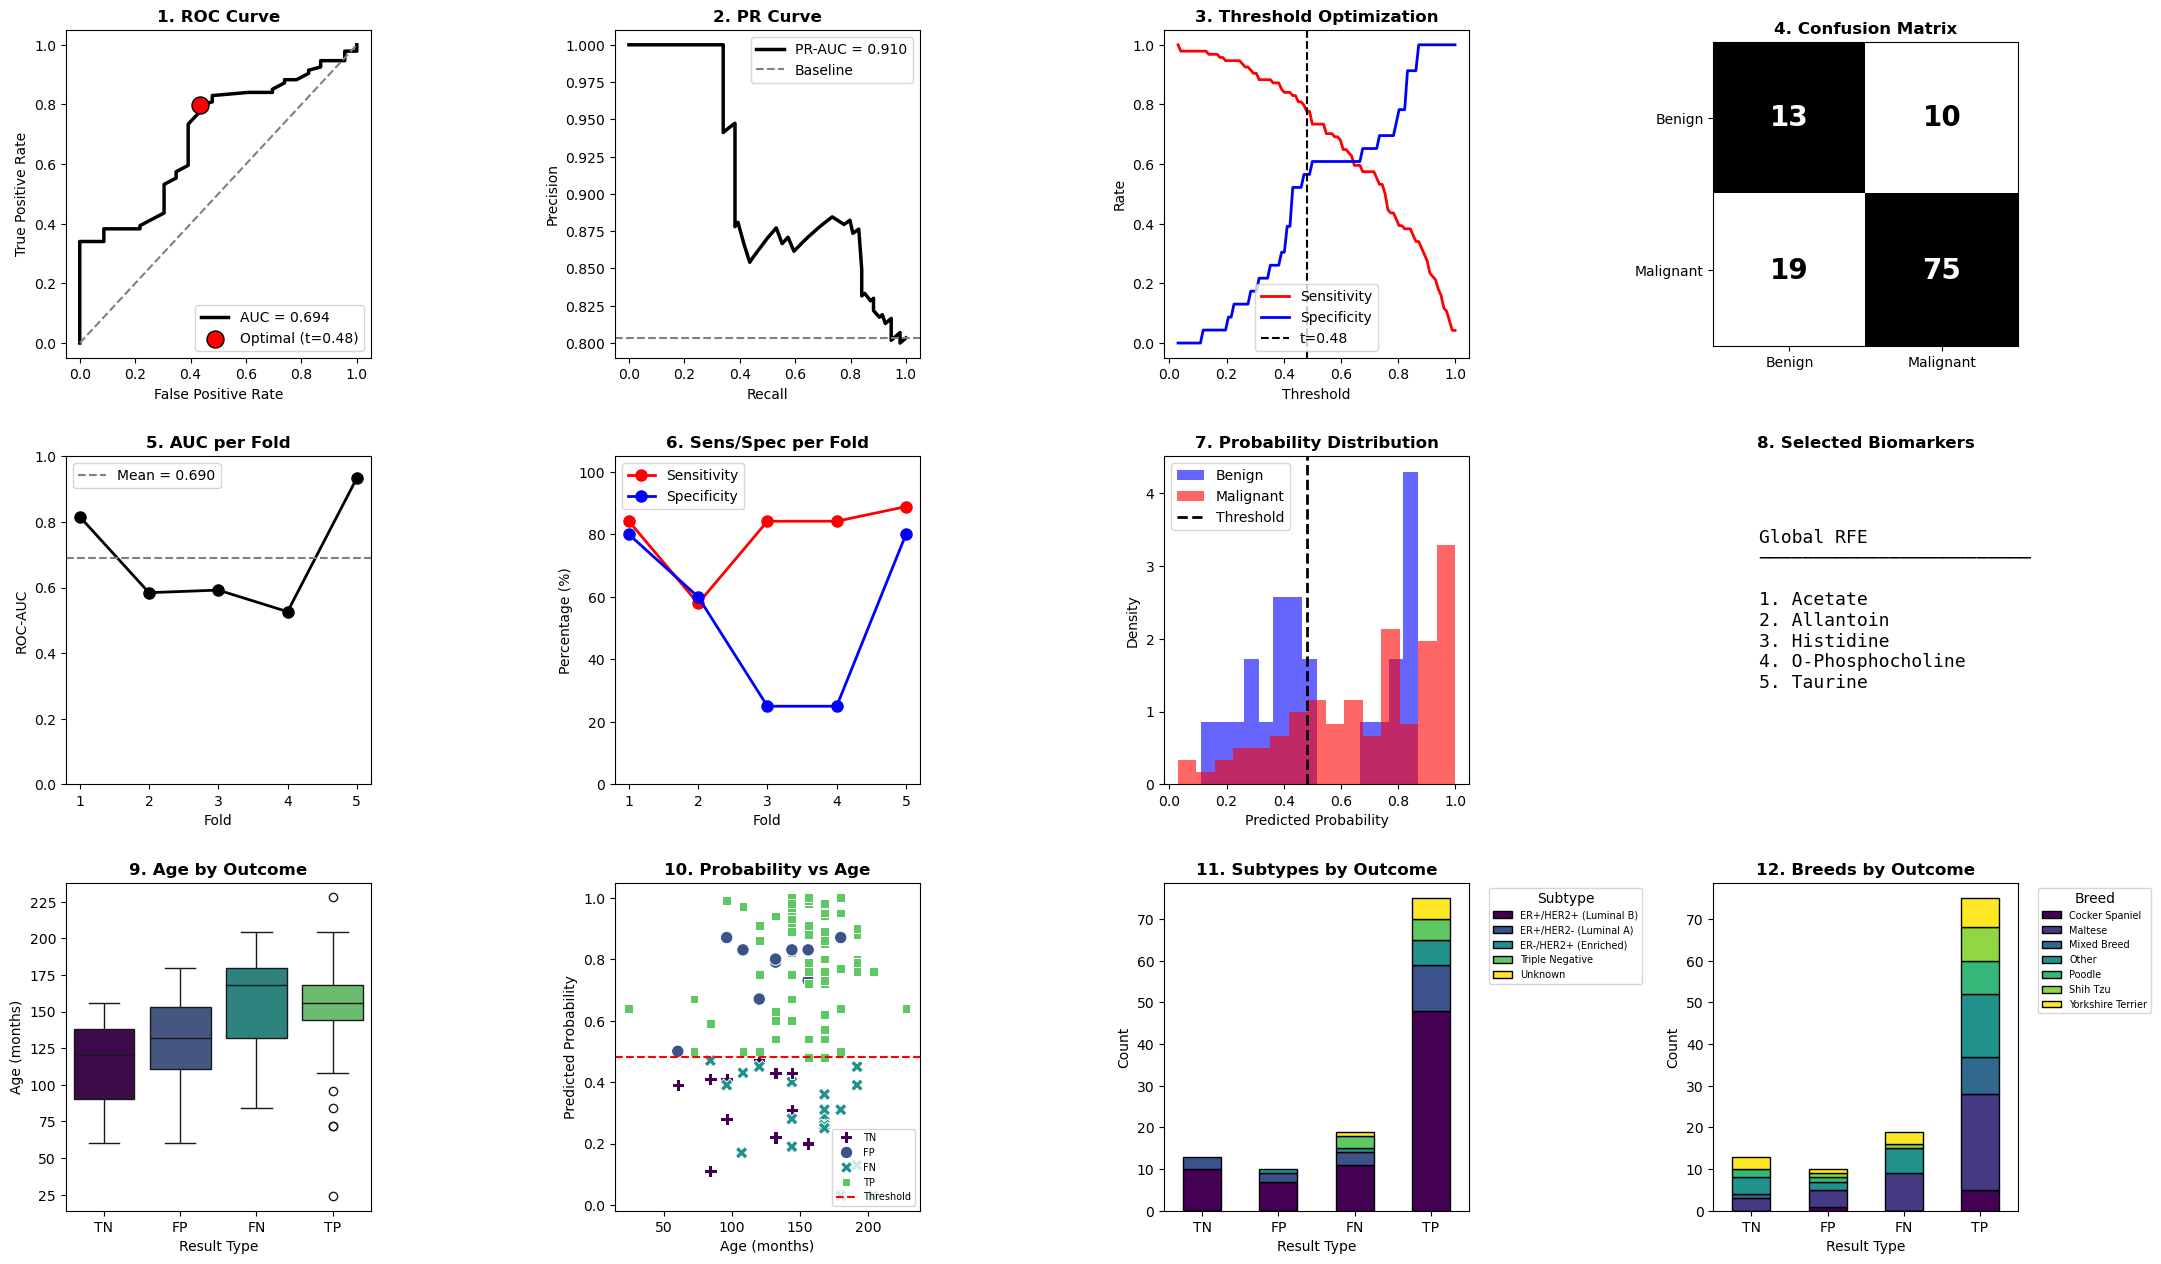

Sensitivity Analysis
Main Model (Metabolites + Breed):     0.6940
With Age (Metabolites + Breed + Age): 0.6798
Difference:                           0.0142


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE 
from sklearn.metrics import (roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN

cv_seed = 42           
resample_seed = 888     
n_features = 5             
fname = 'metabolites_with_clinical_data_reordered2.csv'
df = pd.read_csv(fname)
y = df['Tumor_State'].astype(int).values
sample_ids = df['Sample']

le = LabelEncoder()
df['Breed_Encoded'] = le.fit_transform(df['Breed'].astype(str))
metab_cols = [c for c in df.columns if c not in ['Sample', 'Tumor_State', 'Age_months', 'Breed', 'Breed_Encoded', 'ER Status', 'HER2 Status']]
X_metab = df[metab_cols].dropna(axis=1, thresh=len(df)*0.5)
X_combined = pd.concat([X_metab, df[['Breed_Encoded']]], axis=1)
feat_names = np.array(X_combined.columns)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cv_seed)
y_all, probs_all = [], []
pred_dfs = []
cv_metrics = {'roc_auc': [], 'pr_auc': [], 'sensitivity': [], 'specificity': []}
for fold_num, (tr_idx, te_idx) in enumerate(skf.split(X_combined, y), 1):
    X_tr, X_te = X_combined.iloc[tr_idx], X_combined.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]
    ids_te = sample_ids.iloc[te_idx]
    rf_sel = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=cv_seed)
    pipe = ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('selector', RFE(estimator=rf_sel, n_features_to_select=n_features, step=1)),
        ('resampler', ADASYN(random_state=resample_seed)), 
        ('model', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=cv_seed))
    ])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict_proba(X_te)[:, 1]
    fold_data = pd.DataFrame({
        'sample_id': ids_te.values,
        'true_label': y_te,
        'pred_probability': preds,
        'fold_id': fold_num
    })
    pred_dfs.append(fold_data)
    y_all.extend(y_te)
    probs_all.extend(preds)
    cv_metrics['roc_auc'].append(roc_auc_score(y_te, preds))
    cv_metrics['pr_auc'].append(average_precision_score(y_te, preds))

predictions = pd.concat(pred_dfs, ignore_index=True)
y_all = np.array(y_all)
probs_all = np.array(probs_all)
fpr, tpr, thresh = roc_curve(y_all, probs_all)
roc_auc = auc(fpr, tpr)
j_stats = tpr - fpr
best_idx = np.argmax(j_stats)
cutoff = thresh[best_idx]
predictions['pred_label'] = (predictions['pred_probability'] >= cutoff).astype(int)
predictions.to_csv('secondary_fold_predictions.csv', index=False)
print(f"Saved 'secondary_fold_predictions.csv'")
prec, rec, _ = precision_recall_curve(y_all, probs_all)
pr_auc = auc(rec, prec)
cm = confusion_matrix(y_all, (probs_all >= cutoff).astype(int))
print(f"AUC-PR: {pr_auc:.3f} | AUC-ROC: {roc_auc:.3f}")
print(f"Sensitivity: {cm[1,1]/(cm[1,1]+cm[1,0]):.2%} | Specificity: {cm[0,0]/(cm[0,0]+cm[0,1]):.2%} | Precision (PPV): {cm[1,1]/(cm[1,1]+cm[0,1]):.2%}")
idx = 0
for _, te_idx in skf.split(X_combined, y):
    p_fold = probs_all[idx : idx + len(te_idx)]
    y_fold = y_all[idx : idx + len(te_idx)]
    pred_fold = (p_fold >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_fold, pred_fold).ravel()
    cv_metrics['sensitivity'].append(tp/(tp+fn))
    cv_metrics['specificity'].append(tn/(tn+fp))
    idx += len(te_idx)

pipe_global = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator=RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=cv_seed), 
                     n_features_to_select=n_features, step=1)),
    ('resampler', ADASYN(random_state=resample_seed)),
    ('model', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=cv_seed))
])
pipe_global.fit(X_combined, y)
final_features = feat_names[pipe_global.named_steps['selector'].get_support()]

merged = pd.merge(predictions, df[['Sample', 'Age_months', 'Breed', 'ER Status', 'HER2 Status']], 
                  left_on='sample_id', right_on='Sample', how='left')

def classify_result(row):
    if row['true_label']==1 and row['pred_label']==1: return 'TP'
    if row['true_label']==0 and row['pred_label']==0: return 'TN'
    if row['true_label']==0 and row['pred_label']==1: return 'FP'
    if row['true_label']==1 and row['pred_label']==0: return 'FN'
merged['Result_Type'] = merged.apply(classify_result, axis=1)
def assign_subtype(row):
    er, her2 = row['ER Status'], row['HER2 Status']
    if pd.isna(er) or pd.isna(her2): return 'Unknown'
    if er == 1 and her2 == 0: return 'ER+/HER2- (Luminal A)'
    if er == 1 and her2 == 1: return 'ER+/HER2+ (Luminal B)'
    if er == 0 and her2 == 1: return 'ER-/HER2+ (Enriched)'
    if er == 0 and her2 == 0: return 'Triple Negative'
    return 'Other'
merged['Subtype'] = merged.apply(assign_subtype, axis=1)

top6_breeds = merged['Breed'].value_counts().nlargest(6).index
merged['Breed_Group'] = merged['Breed'].apply(lambda x: x if x in top6_breeds else 'Other')
outcome_colors = {'TN': '#440154', 'FP': '#3b528b', 'FN': '#21918c', 'TP': '#5ec962'}
subtype_palette = {
    'ER+/HER2+ (Luminal B)': '#440154',
    'ER+/HER2- (Luminal A)': '#3b528b',
    'ER-/HER2+ (Enriched)': '#21918c',
    'Triple Negative': '#5ec962',
    'Unknown': '#fde725'
}
fig, axes = plt.subplots(3, 4, figsize=(22, 13))
ax = axes.ravel()

ax[0].plot(fpr, tpr, 'k-', lw=2.5, label=f'AUC = {roc_auc:.3f}')
ax[0].scatter(fpr[best_idx], tpr[best_idx], color='red', s=150, edgecolors='black', 
           label=f'Optimal (t={cutoff:.2f})', zorder=5)
ax[0].plot([0, 1], [0, 1], 'gray', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('1. ROC Curve', fontweight='bold')
ax[0].legend(loc='lower right')
ax[1].plot(rec, prec, 'k-', lw=2.5, label=f'PR-AUC = {pr_auc:.3f}')
ax[1].axhline(y=np.mean(y), color='gray', linestyle='--', label='Baseline')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('2. PR Curve', fontweight='bold')
ax[1].legend()
thresh_range = np.linspace(min(probs_all), max(probs_all), 100)
sens_vals, spec_vals = [], []
for t in thresh_range:
    y_pred = (probs_all >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_all, y_pred).ravel()
    sens_vals.append(tp/(tp+fn))
    spec_vals.append(tn/(tn+fp))
ax[2].plot(thresh_range, sens_vals, 'r-', label='Sensitivity', lw=2)
ax[2].plot(thresh_range, spec_vals, 'b-', label='Specificity', lw=2)
ax[2].axvline(cutoff, color='black', linestyle='--', label=f't={cutoff:.2f}')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Rate')
ax[2].set_title('3. Threshold Optimization', fontweight='bold')
ax[2].legend()
mask = np.array([[1, 0], [0, 1]])
ax[3].imshow(mask, cmap='binary', interpolation='nearest')
for i in range(2):
    for j in range(2):
        ax[3].text(j, i, format(cm[i, j], 'd'), ha="center", va="center", 
                color="white" if mask[i,j]==1 else "black", fontsize=20, fontweight='bold')
ax[3].set_title('4. Confusion Matrix', fontweight='bold')
ax[3].set_xticks([0,1])
ax[3].set_yticks([0,1])
ax[3].set_xticklabels(['Benign', 'Malignant'])
ax[3].set_yticklabels(['Benign', 'Malignant'])
ax[4].plot(range(1,6), cv_metrics['roc_auc'], 'ko-', lw=2, markersize=8)
ax[4].axhline(np.mean(cv_metrics['roc_auc']), color='gray', linestyle='--', 
           label=f'Mean = {np.mean(cv_metrics["roc_auc"]):.3f}')
ax[4].set_xlabel('Fold')
ax[4].set_ylabel('ROC-AUC')
ax[4].set_title('5. AUC per Fold', fontweight='bold')
ax[4].set_ylim([0.0, 1.0])
ax[4].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[4].legend()
ax[5].plot(range(1,6), np.array(cv_metrics['sensitivity'])*100, 'ro-', 
        label='Sensitivity', lw=2, markersize=8)
ax[5].plot(range(1,6), np.array(cv_metrics['specificity'])*100, 'bo-', 
        label='Specificity', lw=2, markersize=8)
ax[5].set_xlabel('Fold')
ax[5].set_ylabel('Percentage (%)')
ax[5].set_title('6. Sens/Spec per Fold', fontweight='bold')
ax[5].legend()
ax[5].set_ylim([0, 105])
ax[6].hist(probs_all[y_all==0], bins=15, alpha=0.6, color='blue', label='Benign', density=True)
ax[6].hist(probs_all[y_all==1], bins=15, alpha=0.6, color='red', label='Malignant', density=True)
ax[6].axvline(cutoff, color='black', linestyle='--', lw=2, label='Threshold')
ax[6].set_xlabel('Predicted Probability')
ax[6].set_ylabel('Density')
ax[6].set_title('7. Probability Distribution', fontweight='bold')
ax[6].legend()
feat_list = "Global RFE\n" + "─"*25 + "\n\n"
for i, feat in enumerate(final_features, 1):
    feat_list += f"{i}. {feat}\n"
ax[7].text(0.15, 0.5, feat_list, fontsize=13, verticalalignment='center', 
         family='monospace', transform=ax[7].transAxes)
ax[7].set_axis_off()
ax[7].set_title('8. Selected Biomarkers', fontweight='bold')
merged['Age_months'] = pd.to_numeric(merged['Age_months'], errors='coerce')
sns.boxplot(data=merged, x='Result_Type', y='Age_months', hue='Result_Type',
            order=['TN','FP','FN','TP'], ax=ax[8], palette=outcome_colors, legend=False)
ax[8].set_title('9. Age by Outcome', fontweight='bold')
ax[8].set_xlabel('Result Type')
ax[8].set_ylabel('Age (months)')
age_lo, age_hi = merged['Age_months'].min(), merged['Age_months'].max()
ax[8].set_ylim([age_lo - 10, age_hi + 10])
sns.scatterplot(data=merged, x='Age_months', y='pred_probability', hue='Result_Type', 
                style='Result_Type', s=80, ax=ax[9], palette=outcome_colors, 
                hue_order=['TN','FP','FN','TP'])
ax[9].axhline(cutoff, color='red', linestyle='--', label='Threshold')
ax[9].set_title('10. Probability vs Age', fontweight='bold')
ax[9].set_xlabel('Age (months)')
ax[9].set_ylabel('Predicted Probability')
ax[9].tick_params(axis='x', rotation=0)
ax[9].locator_params(axis='x', nbins=6)
ax[9].legend(loc='lower right', fontsize=7)
subtype_df = merged.groupby(['Result_Type', 'Subtype']).size().unstack(fill_value=0)
subtype_df = subtype_df.reindex(['TN', 'FP', 'FN', 'TP'])
present = [c for c in subtype_palette.keys() if c in subtype_df.columns]
subtype_df = subtype_df[present]
colors = [subtype_palette[c] for c in subtype_df.columns]
subtype_df.plot(kind='bar', stacked=True, ax=ax[10], color=colors, edgecolor='black')
ax[10].set_title('11. Subtypes by Outcome', fontweight='bold')
ax[10].set_xlabel('Result Type')
ax[10].set_ylabel('Count')
ax[10].set_xticklabels(ax[10].get_xticklabels(), rotation=0)
ax[10].legend(title='Subtype', fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
breed_df = merged.groupby(['Result_Type', 'Breed_Group']).size().unstack(fill_value=0)
breed_df = breed_df.reindex(['TN', 'FP', 'FN', 'TP'])
breed_df.plot(kind='bar', stacked=True, ax=ax[11], colormap='viridis', edgecolor='black')
ax[11].set_title('12. Breeds by Outcome', fontweight='bold')
ax[11].set_xlabel('Result Type')
ax[11].set_ylabel('Count')
ax[11].set_xticklabels(ax[11].get_xticklabels(), rotation=0)
ax[11].legend(title='Breed', fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=1.5)
plt.show()

print("Sensitivity Analysis") # Age
df['Age_months'] = pd.to_numeric(df['Age_months'], errors='coerce')
X_with_age = pd.concat([X_metab, df[['Breed_Encoded']], df[['Age_months']]], axis=1)
def get_cv_auc(X, y):
    aucs = []
    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        pipe = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('selector', RFE(estimator=RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=cv_seed), 
                           n_features_to_select=n_features, step=1)),
            ('resampler', ADASYN(random_state=resample_seed)),
            ('model', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=cv_seed))
        ]) 
        pipe.fit(X_tr, y_tr)
        probs = pipe.predict_proba(X_te)[:, 1]
        aucs.append(roc_auc_score(y_te, probs))
    return np.mean(aucs)
auc_with_age = get_cv_auc(X_with_age, y)
auc_main = roc_auc
print(f"Main Model (Metabolites + Breed):     {auc_main:.4f}")
print(f"With Age (Metabolites + Breed + Age): {auc_with_age:.4f}")
print(f"Difference:                           {abs(auc_main - auc_with_age):.4f}")